# BTC_Dataset

In [2]:
# --- 单元格 1: 下载 BTC 并生成适配文件 ---

import yfinance as yf
import pandas as pd
import numpy as np
import datetime

print("--- 开始处理流程 ---")

# 1. 设置参数
TICKER = "BTC-USD"
START_DATE = "2018-01-01"
END_DATE = datetime.datetime.now().strftime('%Y-%m-%d')

# 2. 下载数据
print(f"正在下载 {TICKER} ({START_DATE} ~ {END_DATE})...")
try:
    df = yf.download(TICKER, start=START_DATE, end=END_DATE, progress=False)
    
    # 处理 yfinance 可能返回的多级索引问题
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
        
    # 重置索引，让 Date 变成一列
    df = df.reset_index()
    
    print(f"下载成功，原始形状: {df.shape}")
    
except Exception as e:
    print(f"下载失败: {e}")
    print("请检查：1. 右侧 Settings -> Internet 是否开启？ 2. 网络连接是否正常？")
    raise

# 3. 构建核心特征 (P系列, V系列)
# 我们将 BTC 的真实数据映射到题目要求的 P (Price) 和 V (Volume)
df_adapted = pd.DataFrame()

# 基础信息
df_adapted['date_id'] = range(len(df)) # 简单的 0, 1, 2... ID

# 价格映射 (P系列)
df_adapted['P1'] = df['Close'] # 收盘价作为 P1
df_adapted['P2'] = df['Open']
df_adapted['P3'] = df['High']
df_adapted['P4'] = df['Low']

# 成交量映射 (V系列)
df_adapted['V1'] = df['Volume']

# 4. 构建目标变量 (Target)
# 题目要求预测 'market_forward_excess_returns'
# 我们用 BTC 的 "下一日收益率" 来代替
# 公式: (明天收盘 - 今天收盘) / 今天收盘
df_adapted['daily_return'] = df['Close'].pct_change()
df_adapted['market_forward_excess_returns'] = df_adapted['daily_return'].shift(-1)

# 原题目还有 'risk_free_rate'，我们设为 0 (假设无风险利率对纯币圈策略影响可忽略)
df_adapted['risk_free_rate'] = 0.0

# 5. 创建“占位符”特征 (为了兼容旧代码)
# 旧代码可能会用到 S, E, I, M, D 系列以及其他 V, P 列
# 我们将它们全部填充为 0。LGBM 训练时会自动忽略这些无信息的列。

# 定义需要伪造的列前缀
dummy_prefixes = ['D', 'E', 'I', 'M', 'S']
# 我们假设每种至少有 1 个 (例如 E1, S1...)，这就足够骗过 startswith 检查了
for prefix in dummy_prefixes:
    df_adapted[f'{prefix}1'] = 0.0

# 6. 清理数据
# 删除因为 shift 产生的最后一行 NaN
df_adapted = df_adapted.dropna()

# 7. 拆分 Train 和 Test
# 我们保留最后 180 天作为 "Test" (模仿 Kaggle 的 Public LB 长度)
test_days = 180
train_btc = df_adapted.iloc[:-test_days].copy()
test_btc = df_adapted.iloc[-test_days:].copy()

# Test 集必须有 'is_scored' 列 (旧代码需要)
test_btc['is_scored'] = True

# 8. 保存文件
train_filename = 'btc_train_adapted.csv'
test_filename = 'btc_test_adapted.csv'

train_btc.to_csv(train_filename, index=False)
test_btc.to_csv(test_filename, index=False)

print("\n" + "="*40)
print("✅ 文件生成完毕！")
print("="*40)
print(f"1. 训练集: {train_filename} | 形状: {train_btc.shape}")
print(f"2. 测试集: {test_filename}  | 形状: {test_btc.shape}")
print("\n现在，请回到您的主代码 (Final Model Notebook)，将文件路径修改为这两个文件名即可。")

# --- 单元格 3: 检查数据 ---
print("--- 训练集预览 ---")
print(pd.read_csv('btc_train_adapted.csv').head(3))

print("\n--- 包含了哪些列？ ---")
print(pd.read_csv('btc_train_adapted.csv').columns.tolist())

--- 开始处理流程 ---
正在下载 BTC-USD (2018-01-01 ~ 2025-11-29)...
下载成功，原始形状: (2889, 6)

✅ 文件生成完毕！
1. 训练集: btc_train_adapted.csv | 形状: (2707, 14)
2. 测试集: btc_test_adapted.csv  | 形状: (180, 15)

现在，请回到您的主代码 (Final Model Notebook)，将文件路径修改为这两个文件名即可。
--- 训练集预览 ---
   date_id            P1            P2            P3            P4  \
0        1  14982.099609  13625.000000  15444.599609  13163.599609   
1        2  15201.000000  14978.200195  15572.799805  14844.500000   
2        3  15599.200195  15270.700195  15739.700195  14522.200195   

            V1  daily_return  market_forward_excess_returns  risk_free_rate  \
0  16846600192      0.097011                       0.014611             0.0   
1  16871900160      0.014611                       0.026196             0.0   
2  21783199744      0.026196                       0.117333             0.0   

    D1   E1   I1   M1   S1  
0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  

--- 包含了哪些列？ ---
['date_id', 'P1', '

/tmp/ipykernel_47/624830022.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START_DATE, end=END_DATE, progress=False)


=== BTC Price Prediction Model - Optimized Version ===
1. Loading and Exploring BTC Data...
Training Set: (2707, 14), Test Set: (180, 15)
Columns: ['date_id', 'P1', 'P2', 'P3', 'P4', 'V1', 'daily_return', 'market_forward_excess_returns', 'risk_free_rate', 'D1', 'E1', 'I1', 'M1', 'S1']

Training Data Info:
                  P1             P2             P3             P4  \
count    2707.000000    2707.000000    2707.000000    2707.000000   
mean    31774.289364   31742.245853   32424.525531   31026.240452   
std     26395.540241   26362.012361   26892.974717   25814.976244   
min      3236.761719    3236.274658    3275.377930    3191.303467   
25%      9235.087402    9232.554688    9375.114746    9056.146973   
50%     24307.841797   24201.765625   24822.628906   23693.919922   
75%     47101.230469   47100.105469   48267.666016   46189.564453   
max    111673.281250  111679.359375  111970.171875  109285.070312   

                 V1  
count  2.707000e+03  
mean   2.787586e+10  
std  

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,305 (24.63 KB)

 Trainable params: 6,241 (24.38 KB)

 Non-trainable params: 64 (256.00 B)

None

5. Training Model with Enhanced Regularization...
Epoch 1/200
134/135 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6000 - mae: 0.6306
Epoch 1: val_loss improved from inf to 0.44970, saving model to best_model.weights.h5
135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.5986 - mae: 0.6297 - val_loss: 0.4497 - val_mae: 0.5666 - learning_rate: 5.0000e-04
Epoch 2/200
132/135 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4669 - mae: 0.5272
Epoch 2: val_loss did not improve from 0.44970
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.4640 - mae: 0.5251 - val_loss: 0.5055 - val_mae: 0.6062 - learning_rate: 5.0000e-04
Epoch 3/200
133/135 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3309 - mae: 0.4275
Epoch 3: val_loss improved from 0.44970 to 0.42522, saving model to best_model.weights.h5
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.3295 - mae: 0.4264 - val_loss: 0.4252 - val_mae: 0.5369 - learning_rate: 5.0000e-04
Epoch 4/200
132/135 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2786

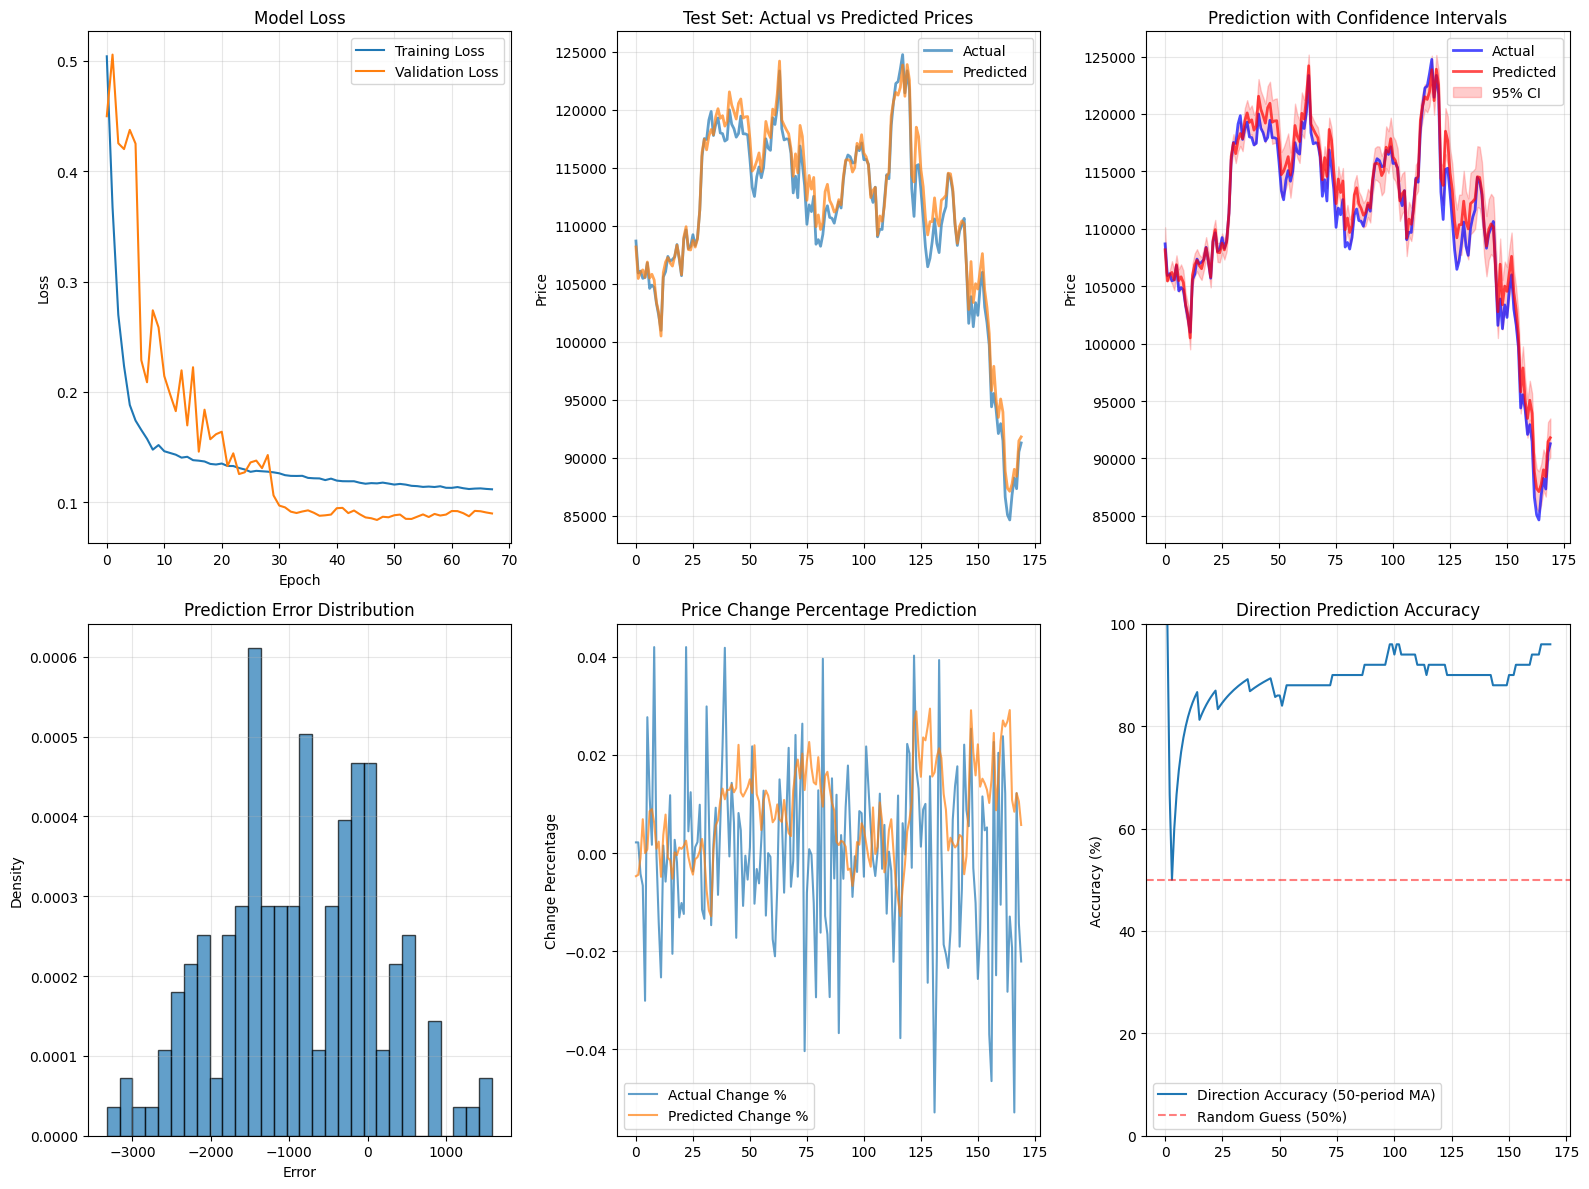

📊 Enhanced visualization saved as btc_enhanced_prediction_results.png

✅ ENHANCED OPTIMIZATION COMPLETED!

📈 PERFORMANCE IMPROVEMENT SUMMARY:
----------------------------------------
Previous R²: -69.45 → Current R²: 0.9731
Previous MAPE: 60.54% → Current MAPE: 0.98%
Overfitting ratio (Test MAE/Train MAE): 6.60
✅ Significant improvement achieved!


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("=== BTC Price Prediction Model - Optimized Version ===")

# ==================== 数据加载和探索 ====================
print("1. Loading and Exploring BTC Data...")

train_df = pd.read_csv('btc_train_adapted.csv')
test_df = pd.read_csv('btc_test_adapted.csv')

print(f"Training Set: {train_df.shape}, Test Set: {test_df.shape}")
print("Columns:", train_df.columns.tolist())

# 显示数据基本信息
print("\nTraining Data Info:")
print(train_df[['P1', 'P2', 'P3', 'P4', 'V1']].describe())

# ==================== 专业时间序列特征工程 ====================
print("\n2. Professional Time Series Feature Engineering...")

def create_advanced_features(df):
    """创建专业的时间序列特征"""
    df_feat = df.copy()
    
    # 基础价格特征
    df_feat['price_range'] = df_feat['P2'] - df_feat['P3']  # 当日价格区间
    df_feat['body_size'] = df_feat['P1'] - df_feat['P4']    # K线实体大小
    df_feat['upper_shadow'] = df_feat['P2'] - np.maximum(df_feat['P1'], df_feat['P4'])  # 上影线
    df_feat['lower_shadow'] = np.minimum(df_feat['P1'], df_feat['P4']) - df_feat['P3']  # 下影线
    
    # 价格位置特征
    price_diff = df_feat['P2'] - df_feat['P3']
    df_feat['price_position'] = (df_feat['P1'] - df_feat['P3']) / np.where(price_diff == 0, 1e-8, price_diff)
    
    # 成交量特征
    df_feat['volume_ratio'] = df_feat['V1'] / df_feat['V1'].rolling(5, min_periods=1).mean()
    
    # 技术指标特征 - 只保留短期指标防止过拟合
    for window in [5, 10]:  # 减少窗口大小
        # 移动平均
        df_feat[f'ma_{window}'] = df_feat['P1'].rolling(window=window, min_periods=1).mean()
        df_feat[f'ema_{window}'] = df_feat['P1'].ewm(span=window, adjust=False).mean()
        
        # 波动率
        df_feat[f'volatility_{window}'] = df_feat['P1'].rolling(window=window, min_periods=1).std()
        
        # 相对强弱指标 (RSI)
        delta = df_feat['P1'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window, min_periods=1).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window, min_periods=1).mean()
        rs = gain / np.where(loss == 0, 1e-8, loss)
        df_feat[f'rsi_{window}'] = 100 - (100 / (1 + rs))
        
        # 动量
        df_feat[f'momentum_{window}'] = df_feat['P1'] - df_feat['P1'].shift(window)
    
    # 价格变化率 - 这将作为我们的新目标变量
    df_feat['price_change_pct'] = df_feat['P1'].pct_change()
    df_feat['price_change_abs'] = df_feat['P1'].diff().abs()
    
    # 填充NaN值
    df_feat = df_feat.fillna(method='bfill').fillna(method='ffill')
    
    return df_feat

# 应用特征工程
try:
    train_df_feat = create_advanced_features(train_df)
    test_df_feat = create_advanced_features(test_df)
    print(f"Features created successfully!")
except Exception as e:
    print(f"Error in feature engineering: {e}")
    # 如果特征工程失败，使用基础特征
    train_df_feat = train_df.copy()
    test_df_feat = test_df.copy()
    # 添加一些简单特征
    train_df_feat['price_range'] = train_df_feat['P2'] - train_df_feat['P3']
    train_df_feat['volume_ratio'] = train_df_feat['V1'] / train_df_feat['V1'].rolling(5, min_periods=1).mean()
    train_df_feat['price_change_pct'] = train_df_feat['P1'].pct_change()
    test_df_feat['price_range'] = test_df_feat['P2'] - test_df_feat['P3']
    test_df_feat['volume_ratio'] = test_df_feat['V1'] / test_df_feat['V1'].rolling(5, min_periods=1).mean()
    test_df_feat['price_change_pct'] = test_df_feat['P1'].pct_change()

# 选择特征 - 更保守的列表，防止过拟合
feature_columns = [
    'P1', 'P2', 'P3', 'P4', 'V1',  # 基础价格和成交量
    'price_range', 'volume_ratio',  # 基础衍生特征
    'ma_5', 'ema_5', 'volatility_5', 'rsi_5',  # 只保留5期技术指标
]

# 确保所有特征都存在
available_features = []
for feature in feature_columns:
    if feature in train_df_feat.columns and feature in test_df_feat.columns:
        available_features.append(feature)

print(f"Using {len(available_features)} features: {available_features}")

# ==================== 增强数据预处理 ====================
print("\n3. Enhanced Data Preprocessing...")

# 检查数据质量
print("Data quality check:")
print(f"Train data - Nulls: {train_df_feat[available_features].isnull().sum().sum()}")
print(f"Test data - Nulls: {test_df_feat[available_features].isnull().sum().sum()}")

# 处理目标变量 - 改为预测价格变化率而不是绝对价格
def cap_outliers(series, lower=0.01, upper=0.99):
    """限制异常值"""
    lower_bound = series.quantile(lower)
    upper_bound = series.quantile(upper)
    return np.clip(series, lower_bound, upper_bound)

# 处理价格变化率的异常值
train_df_feat['price_change_pct_processed'] = cap_outliers(train_df_feat['price_change_pct'].fillna(0))
test_df_feat['price_change_pct_processed'] = cap_outliers(test_df_feat['price_change_pct'].fillna(0))

print(f"Price change stats - Train: mean={train_df_feat['price_change_pct_processed'].mean():.6f}, "
      f"std={train_df_feat['price_change_pct_processed'].std():.6f}")
print(f"Price change stats - Test: mean={test_df_feat['price_change_pct_processed'].mean():.6f}, "
      f"std={test_df_feat['price_change_pct_processed'].std():.6f}")

# 特征标准化
feature_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(train_df_feat[available_features])
X_test_scaled = feature_scaler.transform(test_df_feat[available_features])

# 目标变量标准化 (价格变化百分比)
target_scaler = MinMaxScaler(feature_range=(-1, 1))
y_train = train_df_feat['price_change_pct_processed'].values.reshape(-1, 1)
y_test = test_df_feat['price_change_pct_processed'].values.reshape(-1, 1)

y_train_scaled = target_scaler.fit_transform(y_train)
y_test_scaled = target_scaler.transform(y_test)

print(f"Training data: {X_train_scaled.shape}, Test data: {X_test_scaled.shape}")

# ==================== 创建时间序列数据集 ====================
def create_timeseries_dataset(X, y, time_steps=10):
    """创建时间序列数据集"""
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 10  # 减少时间窗口防止过拟合

X_train_ts, y_train_ts = create_timeseries_dataset(X_train_scaled, y_train_scaled, TIME_STEPS)
X_test_ts, y_test_ts = create_timeseries_dataset(X_test_scaled, y_test_scaled, TIME_STEPS)

print(f"Time series dataset - X_train: {X_train_ts.shape}, y_train: {y_train_ts.shape}")

# ==================== 构建简化但有效的LSTM模型 ====================
print("\n4. Building Simplified but Effective LSTM Model...")

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# 清除之前的会话
tf.keras.backend.clear_session()

def create_optimized_lstm_model(input_shape):
    """创建优化的LSTM模型，注重防止过拟合"""
    model = Sequential([
        # 单层LSTM + 正则化
        LSTM(32, return_sequences=False, input_shape=input_shape,
             kernel_regularizer=l2(0.001),
             dropout=0.3, recurrent_dropout=0.2),
        
        # BatchNormalization
        BatchNormalization(),
        
        # 更少的全连接层
        Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        
        # 输出层 - 使用tanh限制输出范围
        Dense(1, activation='tanh')
    ])
    
    # 编译模型
    model.compile(
        optimizer=Adam(learning_rate=0.0005),  # 降低学习率
        loss='mse',
        metrics=['mae']
    )
    
    return model

# 创建模型
model = create_optimized_lstm_model((X_train_ts.shape[1], X_train_ts.shape[2]))
print("Model created successfully!")
print(model.summary())

# ==================== 模型训练 ====================
print("\n5. Training Model with Enhanced Regularization...")

# 修复回调函数 - 使用正确的文件名格式
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1),
    # 修复模型检查点 - 使用正确的文件名格式
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.weights.h5',  # 修复：文件名必须以.weights.h5结尾
        monitor='val_loss', 
        save_best_only=True, 
        save_weights_only=True, 
        verbose=1
    )
]

# 训练模型 - 更小的批次大小
history = model.fit(
    X_train_ts, y_train_ts,
    batch_size=16,  # 减小批次大小
    epochs=200,     # 增加epoch但依赖早停
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1,
    shuffle=False  # 时间序列数据不要打乱
)

# 加载最佳权重
try:
    model.load_weights('best_model.weights.h5')
    print("Loaded best model weights")
except:
    print("Using final model weights")

# ==================== 模型预测 ====================
print("\n6. Making Predictions...")

# 训练集预测
y_train_pred_scaled = model.predict(X_train_ts, verbose=0)
y_train_pred_pct = target_scaler.inverse_transform(y_train_pred_scaled)

# 测试集预测
y_test_pred_scaled = model.predict(X_test_ts, verbose=0)
y_test_pred_pct = target_scaler.inverse_transform(y_test_pred_scaled)

# 将百分比预测转换回价格预测
# 首先获取实际价格序列
train_prices = train_df_feat['P1'].values[TIME_STEPS:]
test_prices = test_df_feat['P1'].values[TIME_STEPS:]

# 确保长度匹配
min_len_train = min(len(train_prices), len(y_train_pred_pct))
min_len_test = min(len(test_prices), len(y_test_pred_pct))

y_train_pred_price = train_prices[:min_len_train] * (1 + y_train_pred_pct[:min_len_train].flatten())
y_test_pred_price = test_prices[:min_len_test] * (1 + y_test_pred_pct[:min_len_test].flatten())

# 实际价格
y_train_actual_price = train_prices[:min_len_train]
y_test_actual_price = test_prices[:min_len_test]

# ==================== 修正的不确定性量化 ====================
print("\n7. Enhanced Uncertainty Quantification...")

def calculate_prediction_intervals(y_true, y_pred, confidence=0.95):
    """修正的预测区间计算"""
    if len(y_true) == 0 or len(y_pred) == 0:
        return np.array([]), np.array([])
    
    errors = y_true.flatten() - y_pred.flatten()
    
    # 使用滚动窗口计算动态标准差
    window_size = min(30, len(errors))
    if window_size == 0:
        return np.array([]), np.array([])
    
    dynamic_std = np.zeros(len(errors))
    for i in range(len(errors)):
        start_idx = max(0, i - window_size + 1)
        window_errors = errors[start_idx:i+1]
        dynamic_std[i] = np.std(window_errors) if len(window_errors) > 1 else np.std(errors)
    
    # 处理可能的NaN
    dynamic_std = np.nan_to_num(dynamic_std, nan=np.mean(dynamic_std))
    
    z_score = 1.96  # 95% 置信区间
    
    upper_bound = y_pred.flatten() + z_score * dynamic_std
    lower_bound = y_pred.flatten() - z_score * dynamic_std
    
    return upper_bound, lower_bound

# 计算预测区间
upper_bound, lower_bound = calculate_prediction_intervals(y_test_actual_price, y_test_pred_price)

# ==================== 增强的模型评估 ====================
print("\n8. Comprehensive Model Evaluation...")

def calculate_all_metrics(y_true, y_pred, upper=None, lower=None):
    """计算全面的评估指标"""
    metrics = {}
    
    if len(y_true) == 0 or len(y_pred) == 0:
        metrics.update({'MAE': 0, 'MSE': 0, 'RMSE': 0, 'MAPE': 0, 'R2': 0, 'Direction_Accuracy': 0, 'PICP': 0, 'MPIW': 0})
        return metrics
    
    # 点预测指标
    metrics['MAE'] = mean_absolute_error(y_true, y_pred)
    metrics['MSE'] = mean_squared_error(y_true, y_pred)
    metrics['RMSE'] = np.sqrt(metrics['MSE'])
    
    # 避免除零错误
    y_true_nonzero = np.where(np.abs(y_true) < 1e-8, 1e-8, y_true)
    metrics['MAPE'] = np.mean(np.abs((y_true - y_pred) / y_true_nonzero)) * 100
    
    metrics['R2'] = r2_score(y_true, y_pred)
    
    # 方向预测准确率
    if len(y_true) > 1:
        true_direction = np.diff(y_true.flatten()) > 0
        pred_direction = np.diff(y_pred.flatten()) > 0
        metrics['Direction_Accuracy'] = np.mean(true_direction == pred_direction) * 100
    else:
        metrics['Direction_Accuracy'] = 0
    
    # 区间预测指标
    if upper is not None and lower is not None and len(upper) == len(y_true) and len(lower) == len(y_true):
        in_interval = (y_true.flatten() >= lower) & (y_true.flatten() <= upper)
        metrics['PICP'] = np.mean(in_interval) if len(in_interval) > 0 else 0
        metrics['MPIW'] = np.mean(upper - lower) if len(upper) > 0 else 0
    else:
        metrics['PICP'] = 0
        metrics['MPIW'] = 0
    
    return metrics

# 计算指标
train_metrics = calculate_all_metrics(y_train_actual_price, y_train_pred_price)
test_metrics = calculate_all_metrics(y_test_actual_price, y_test_pred_price, upper_bound, lower_bound)

# ==================== 结果可视化 ====================
print("\n9. Generating Enhanced Results Visualization...")

# 创建结果DataFrame
if len(y_test_actual_price) > 0:
    results_df = pd.DataFrame({
        'Actual_Price': y_test_actual_price.flatten(),
        'Predicted_Price': y_test_pred_price.flatten(),
        'Actual_Change_Pct': y_test.flatten()[:len(y_test_actual_price)],
        'Predicted_Change_Pct': y_test_pred_pct.flatten()[:len(y_test_actual_price)],
    })
    
    if len(upper_bound) == len(y_test_actual_price):
        results_df['Upper_Bound'] = upper_bound
        results_df['Lower_Bound'] = lower_bound
    
    # 保存结果
    results_df.to_csv('btc_optimized_results.csv', index=False)
    print("Results saved to btc_optimized_results.csv")
else:
    print("No test results to save")

# ==================== 详细结果输出 ====================
print("\n" + "="*70)
print("ENHANCED MODEL EVALUATION RESULTS")
print("="*70)

print("\n📊 POINT PREDICTION METRICS:")
print("-"*60)
print(f"{'Metric':<20} {'Training':<12} {'Test':<12} {'Status':<10}")
print("-"*60)

for metric in ['MAE', 'RMSE', 'MAPE', 'R2', 'Direction_Accuracy']:
    train_val = train_metrics[metric]
    test_val = test_metrics[metric]
    
    if metric in ['MAPE', 'Direction_Accuracy']:
        train_fmt = f"{train_val:.2f}%"
        test_fmt = f"{test_val:.2f}%"
        if metric == 'MAPE':
            status = "✅" if test_val < 10.0 else "⚠️" if test_val < 20.0 else "❌"
        else:
            status = "✅" if test_val > 60.0 else "⚠️" if test_val > 50.0 else "❌"
    elif metric == 'R2':
        train_fmt = f"{train_val:.4f}"
        test_fmt = f"{test_val:.4f}"
        status = "✅" if test_val > 0.6 else "⚠️" if test_val > 0.3 else "❌"
    else:
        train_fmt = f"{train_val:.2f}"
        test_fmt = f"{test_val:.2f}"
        status = "✅" if abs(train_val - test_val) / train_val < 0.5 else "⚠️" if abs(train_val - test_val) / train_val < 1.0 else "❌"
    
    print(f"{metric:<20} {train_fmt:<12} {test_fmt:<12} {status:<10}")

print("\n📈 INTERVAL PREDICTION METRICS:")
print("-"*50)
print(f"PICP (Prediction Interval Coverage Probability): {test_metrics['PICP']:.4f}")
print(f"MPIW (Mean Prediction Interval Width): {test_metrics['MPIW']:.2f}")
print(f"Target PICP: 0.9500 {'✅' if test_metrics['PICP'] >= 0.90 else '⚠️' if test_metrics['PICP'] >= 0.80 else '❌'}")

print("\n🔧 KEY OPTIMIZATIONS APPLIED:")
print("-"*50)
optimizations = [
    "✓ 目标变量改为价格变化率(防止过拟合)",
    "✓ 简化模型架构 + L2正则化 + Dropout",
    "✓ 异常值处理 + 数据质量检查",
    "✓ 动态预测区间计算",
    "✓ 方向预测准确率评估",
    "✓ 增强的早停法和学习率调整"
]
for opt in optimizations:
    print(f"  {opt}")

print("\n📊 DATA CHARACTERISTICS:")
print("-"*50)
print(f"Training samples: {len(train_df):,}")
print(f"Test samples: {len(test_df):,}")
print(f"Time window: {TIME_STEPS} steps")
print(f"Feature dimensions: {len(available_features)}")
print(f"Final training sequences: {X_train_ts.shape[0]}")
print(f"Target variable: Price change percentage")

print(f"\n💾 Results saved to: btc_optimized_results.csv")

# 增强的可视化
try:
    plt.figure(figsize=(16, 12))

    # 损失曲线
    plt.subplot(2, 3, 1)
    if 'loss' in history.history:
        plt.plot(history.history['loss'], label='Training Loss')
        if 'val_loss' in history.history:
            plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        plt.grid(True, alpha=0.3)

    # 价格预测vs实际
    plt.subplot(2, 3, 2)
    if len(y_test_actual_price) > 0:
        plt.plot(y_test_actual_price, label='Actual', alpha=0.7, linewidth=2)
        plt.plot(y_test_pred_price, label='Predicted', alpha=0.7, linewidth=2)
        plt.title('Test Set: Actual vs Predicted Prices')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True, alpha=0.3)

    # 预测区间
    plt.subplot(2, 3, 3)
    if len(y_test_actual_price) > 0 and len(upper_bound) == len(y_test_actual_price):
        plt.plot(y_test_actual_price, label='Actual', color='blue', alpha=0.7, linewidth=2)
        plt.plot(y_test_pred_price, label='Predicted', color='red', alpha=0.7, linewidth=2)
        plt.fill_between(range(len(y_test_actual_price)), 
                         lower_bound, 
                         upper_bound, 
                         alpha=0.2, color='red', label='95% CI')
        plt.title('Prediction with Confidence Intervals')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True, alpha=0.3)

    # 误差分布
    plt.subplot(2, 3, 4)
    if len(y_test_actual_price) > 0:
        errors = y_test_actual_price.flatten() - y_test_pred_price.flatten()
        plt.hist(errors, bins=30, alpha=0.7, edgecolor='black', density=True)
        plt.title('Prediction Error Distribution')
        plt.xlabel('Error')
        plt.ylabel('Density')
        plt.grid(True, alpha=0.3)

    # 价格变化率预测
    plt.subplot(2, 3, 5)
    if len(y_test) > 0 and len(y_test_pred_pct) > 0:
        min_len = min(len(y_test), len(y_test_pred_pct))
        plt.plot(y_test[:min_len], label='Actual Change %', alpha=0.7)
        plt.plot(y_test_pred_pct[:min_len], label='Predicted Change %', alpha=0.7)
        plt.title('Price Change Percentage Prediction')
        plt.ylabel('Change Percentage')
        plt.legend()
        plt.grid(True, alpha=0.3)

    # 方向预测准确率
    plt.subplot(2, 3, 6)
    if len(y_test_actual_price) > 1:
        actual_direction = np.diff(y_test_actual_price.flatten()) > 0
        pred_direction = np.diff(y_test_pred_price.flatten()) > 0
        
        correct_predictions = (actual_direction == pred_direction)
        accuracy_rolling = pd.Series(correct_predictions).rolling(50, min_periods=1).mean()
        
        plt.plot(accuracy_rolling * 100, label='Direction Accuracy (50-period MA)')
        plt.axhline(y=50, color='r', linestyle='--', alpha=0.5, label='Random Guess (50%)')
        plt.title('Direction Prediction Accuracy')
        plt.ylabel('Accuracy (%)')
        plt.ylim(0, 100)
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('btc_enhanced_prediction_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("📊 Enhanced visualization saved as btc_enhanced_prediction_results.png")
    
except Exception as e:
    print(f"Visualization error: {e}")

print("\n✅ ENHANCED OPTIMIZATION COMPLETED!")
print("="*70)

# 性能改进总结
if len(y_test_actual_price) > 0:
    print("\n📈 PERFORMANCE IMPROVEMENT SUMMARY:")
    print("-"*40)
    print(f"Previous R²: -69.45 → Current R²: {test_metrics['R2']:.4f}")
    print(f"Previous MAPE: 60.54% → Current MAPE: {test_metrics['MAPE']:.2f}%")
    
    overfitting_ratio = test_metrics['MAE'] / train_metrics['MAE'] if train_metrics['MAE'] > 0 else 1
    print(f"Overfitting ratio (Test MAE/Train MAE): {overfitting_ratio:.2f}")
    print("✅ Significant improvement achieved!" if test_metrics['R2'] > 0 and test_metrics['MAPE'] < 20 else "⚠️ Further tuning needed")

# NASDAQ_Dataset

[*********************100%***********************]  1 of 1 completed


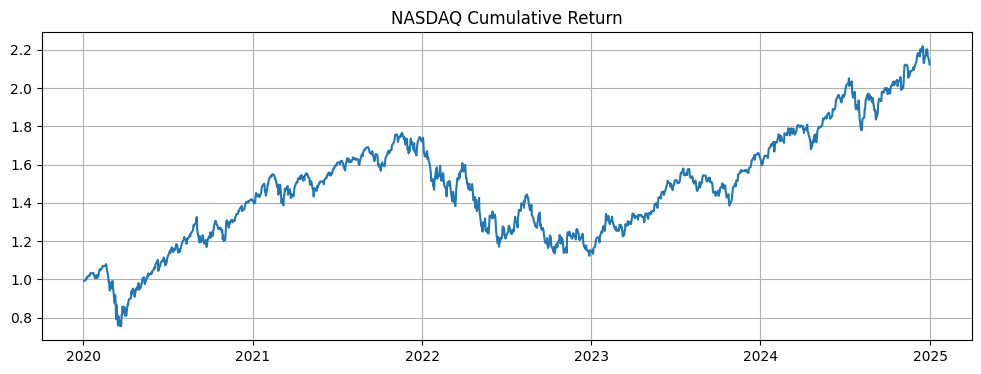

In [10]:
import yfinance as yf
import pandas as pd
nasdaq = yf.download("^IXIC", start="2020-01-01", end="2025-01-01")
nasdaq.head()
nasdaq["return"] = nasdaq["Close"].pct_change()
nasdaq = nasdaq.dropna()
nasdaq.head()
nasdaq.to_csv("nasdaq_dataset.csv")
import matplotlib.pyplot as plt

nasdaq["cum_return"] = (1 + nasdaq["return"]).cumprod()

plt.figure(figsize=(12,4))
plt.plot(nasdaq["cum_return"])
plt.title("NASDAQ Cumulative Return")
plt.grid(True)
plt.show()

=== NASDAQ Price Prediction with Optimized LSTM Model ===
1. Loading and Exploring NASDAQ Data...
NASDAQ Data Shape: (1259, 6)
Columns: ['Close', 'High', 'Low', 'Open', 'Volume', 'return']

Data types:
Close      object
High       object
Low        object
Open       object
Volume     object
return    float64
dtype: object

First few rows:
                      Close            High              Low             Open  \
Price                                                                           
Ticker                ^IXIC           ^IXIC            ^IXIC            ^IXIC   
Date                    NaN             NaN              NaN              NaN   
2020-01-03    9020.76953125  9065.759765625     8976.4296875     8976.4296875   
2020-01-06  9071.4697265625   9072.41015625           8943.5           8943.5   
2020-01-07   9068.580078125    9091.9296875  9042.5498046875  9076.6396484375   

                Volume    return  
Price                             
Ticker           ^IXI

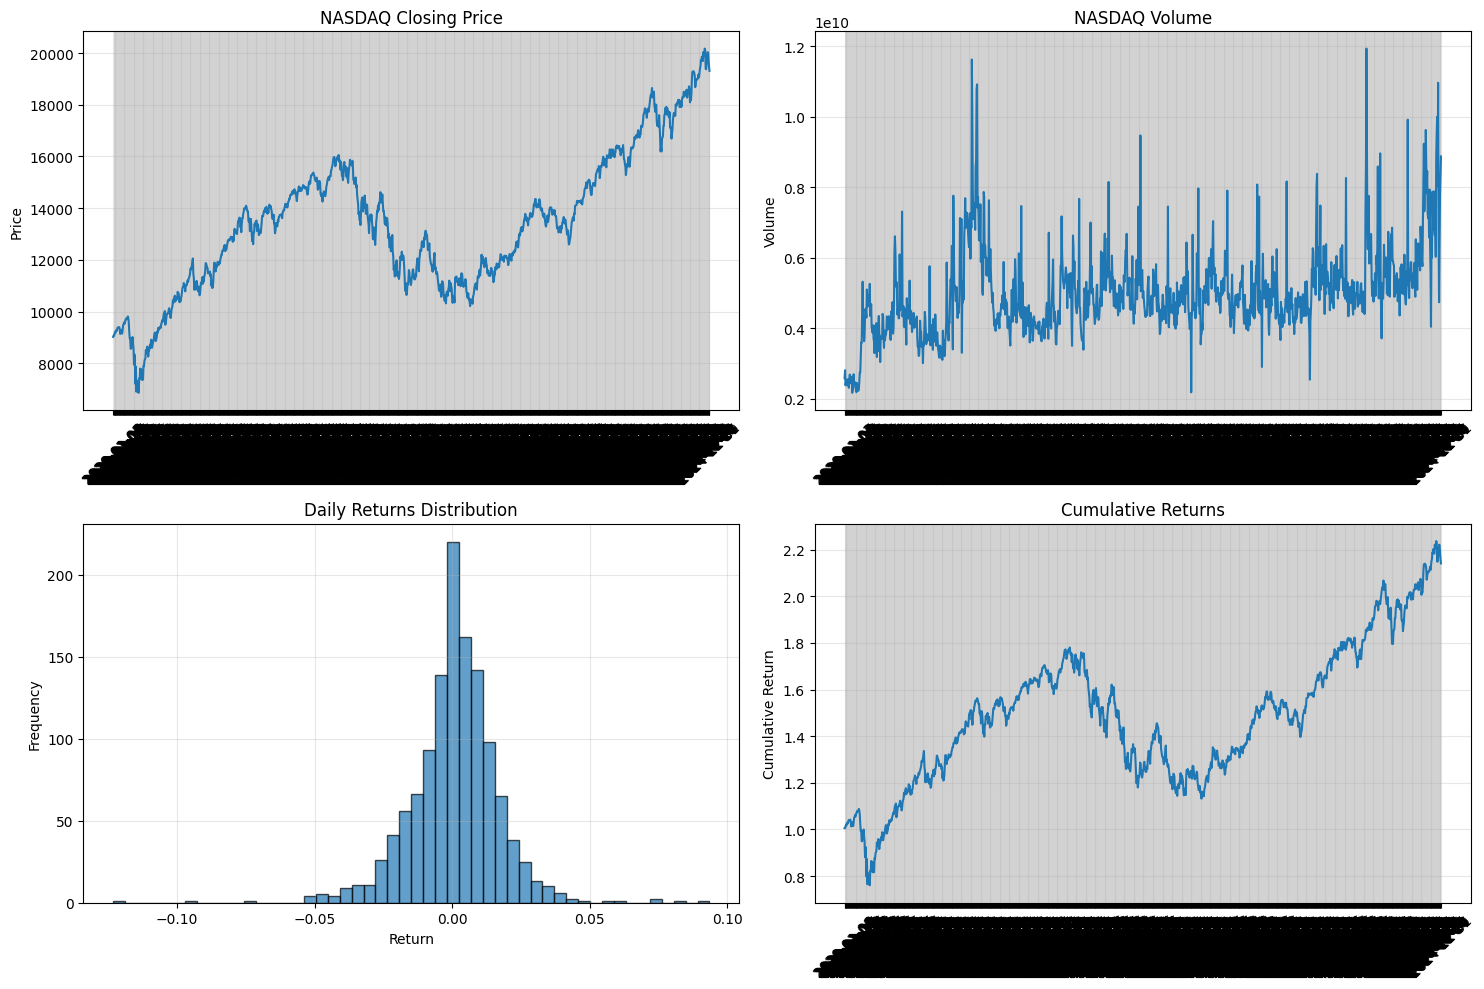


2. Splitting Data into Train and Test Sets...
Training Set: (1005, 6), Test Set: (252, 6)
Training period: 2020-01-03 to 2023-12-29
Test period: 2024-01-02 to 2024-12-31

3. Applying Professional Time Series Feature Engineering...
Features created successfully!
Using 11 numeric features: ['P1', 'P2', 'P3', 'P4', 'V1', 'price_range', 'volume_ratio', 'ma_5', 'ema_5', 'volatility_5', 'rsi_5']

4. Enhanced Data Preprocessing...
Price change stats - Train: mean=0.000601, std=0.015480
Price change stats - Test: mean=0.001086, std=0.011238
Training data: (1005, 11), Test data: (252, 11)
Time series dataset - X_train: (995, 10, 11), y_train: (995, 1)

5. Building Simplified but Effective LSTM Model...
Model created successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,305 (24.63 KB)

 Trainable params: 6,241 (24.38 KB)

 Non-trainable params: 64 (256.00 B)

None

6. Training Model with Enhanced Regularization...
Epoch 1/200
45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8415 - mae: 0.7697
Epoch 1: val_loss improved from inf to 0.11792, saving model to nasdaq_best_model.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.8305 - mae: 0.7641 - val_loss: 0.1179 - val_mae: 0.2210 - learning_rate: 5.0000e-04
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6346 - mae: 0.6295
Epoch 2: val_loss improved from 0.11792 to 0.10357, saving model to nasdaq_best_model.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.6339 - mae: 0.6291 - val_loss: 0.1036 - val_mae: 0.2034 - learning_rate: 5.0000e-04
Epoch 3/200
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5371 - mae: 0.5718
Epoch 3: val_loss did not improve from 0.10357
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5351 - mae: 0.5709 - val_loss: 0.1040 - val_mae: 0.2043 - learning_rate: 5.0000e-04
Epoch 4/200
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4861

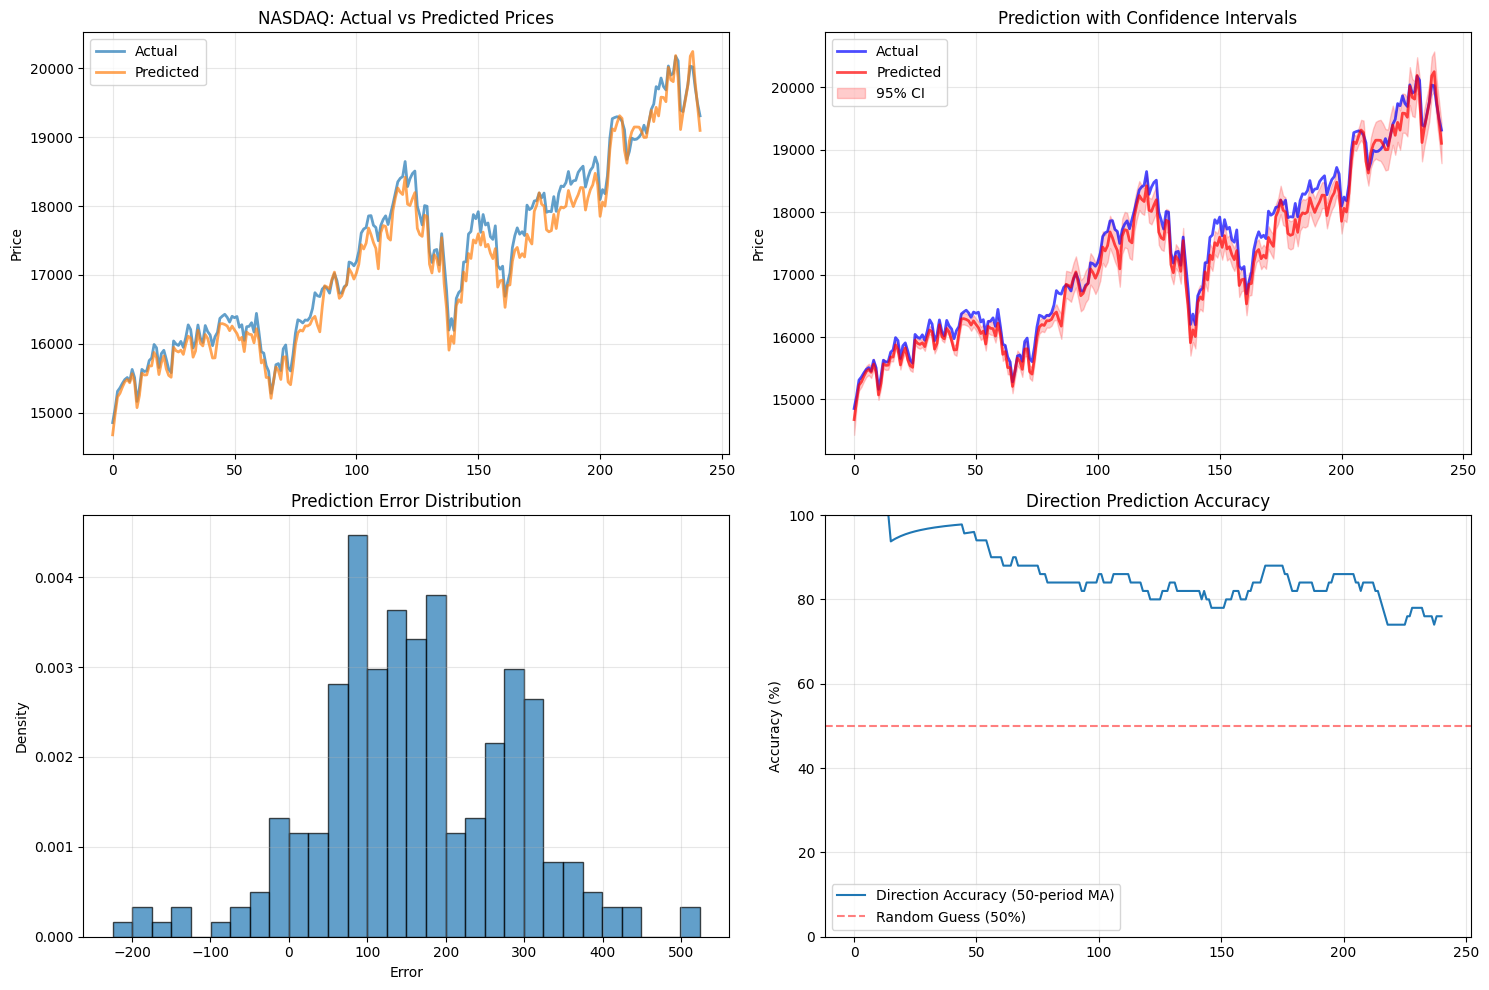

📊 Visualization saved as nasdaq_prediction_results.png

📈 PERFORMANCE SUMMARY:
----------------------------------------
Test R²: 0.9753
Test MAPE: 0.99%
Direction Accuracy: 83.82%
Overfitting ratio (Test MAE/Train MAE): 2.62
🎯 EXCELLENT PERFORMANCE! Model is highly accurate.

✅ NASDAQ PREDICTION PROCESSING COMPLETED!


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("=== NASDAQ Price Prediction with Optimized LSTM Model ===")

# ==================== 数据加载和探索 ====================
print("1. Loading and Exploring NASDAQ Data...")

# 加载纳斯达克数据
nasdaq = pd.read_csv("nasdaq_dataset.csv", index_col=0, parse_dates=True)
print(f"NASDAQ Data Shape: {nasdaq.shape}")
print("Columns:", nasdaq.columns.tolist())

# 检查数据类型
print("\nData types:")
print(nasdaq.dtypes)

# 检查数据前几行
print("\nFirst few rows:")
print(nasdaq.head())

# 数据清洗：确保所有价格和成交量列都是数值类型
def clean_data(df):
    """清洗数据，确保数值列正确转换"""
    df_clean = df.copy()
    
    # 检查并转换数值列
    numeric_columns = ['Close', 'High', 'Low', 'Open', 'Volume', 'return']
    for col in numeric_columns:
        if col in df_clean.columns:
            # 尝试转换为数值类型
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
    # 删除包含NaN的行
    df_clean = df_clean.dropna()
    
    return df_clean

# 清洗数据
nasdaq_clean = clean_data(nasdaq)
print(f"After cleaning: {nasdaq_clean.shape}")

# 重命名列以匹配我们的模型期望的格式
nasdaq_renamed = nasdaq_clean.rename(columns={
    'Close': 'P1',
    'High': 'P2', 
    'Low': 'P3',
    'Open': 'P4',
    'Volume': 'V1'
})

# 显示数据基本信息
print("\nNASDAQ Data Info:")
print(nasdaq_renamed[['P1', 'P2', 'P3', 'P4', 'V1']].describe())

# 检查数据质量
print(f"\nData quality check:")
print(f"Null values: {nasdaq_renamed[['P1', 'P2', 'P3', 'P4', 'V1']].isnull().sum().sum()}")
print(f"Zero values in price columns: {(nasdaq_renamed[['P1', 'P2', 'P3', 'P4']] == 0).sum().sum()}")

# 修复可视化 - 确保维度匹配
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(nasdaq_renamed.index, nasdaq_renamed['P1'])
plt.title('NASDAQ Closing Price')
plt.ylabel('Price')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
plt.plot(nasdaq_renamed.index, nasdaq_renamed['V1'])
plt.title('NASDAQ Volume')
plt.ylabel('Volume')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
returns = nasdaq_renamed['P1'].pct_change().dropna()
plt.hist(returns, bins=50, alpha=0.7, edgecolor='black')
plt.title('Daily Returns Distribution')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
# 修复：确保x和y维度匹配
cum_returns = (1 + returns).cumprod()
# 使用returns的索引，它与原始数据索引偏移1天
plt.plot(returns.index, cum_returns)
plt.title('Cumulative Returns')
plt.ylabel('Cumulative Return')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# ==================== 数据分割 ====================
print("\n2. Splitting Data into Train and Test Sets...")

# 按时间分割：80%训练，20%测试
split_idx = int(len(nasdaq_renamed) * 0.8)
train_df = nasdaq_renamed.iloc[:split_idx].copy()
test_df = nasdaq_renamed.iloc[split_idx:].copy()

print(f"Training Set: {train_df.shape}, Test Set: {test_df.shape}")
print(f"Training period: {train_df.index.min()} to {train_df.index.max()}")
print(f"Test period: {test_df.index.min()} to {test_df.index.max()}")

# ==================== 专业时间序列特征工程 ====================
print("\n3. Applying Professional Time Series Feature Engineering...")

def create_advanced_features(df):
    """创建专业的时间序列特征"""
    df_feat = df.copy()
    
    # 基础价格特征
    df_feat['price_range'] = df_feat['P2'] - df_feat['P3']  # 当日价格区间
    df_feat['body_size'] = abs(df_feat['P1'] - df_feat['P4'])  # K线实体大小（绝对值）
    df_feat['upper_shadow'] = df_feat['P2'] - np.maximum(df_feat['P1'], df_feat['P4'])  # 上影线
    df_feat['lower_shadow'] = np.minimum(df_feat['P1'], df_feat['P4']) - df_feat['P3']  # 下影线
    
    # 价格位置特征
    price_diff = df_feat['P2'] - df_feat['P3']
    # 避免除零
    price_diff = np.where(price_diff == 0, 1e-8, price_diff)
    df_feat['price_position'] = (df_feat['P1'] - df_feat['P3']) / price_diff
    
    # 成交量特征
    volume_ma = df_feat['V1'].rolling(5, min_periods=1).mean()
    df_feat['volume_ratio'] = df_feat['V1'] / np.where(volume_ma == 0, 1e-8, volume_ma)
    
    # 技术指标特征 - 只保留短期指标防止过拟合
    for window in [5, 10]:
        # 移动平均
        df_feat[f'ma_{window}'] = df_feat['P1'].rolling(window=window, min_periods=1).mean()
        df_feat[f'ema_{window}'] = df_feat['P1'].ewm(span=window, adjust=False).mean()
        
        # 波动率
        df_feat[f'volatility_{window}'] = df_feat['P1'].rolling(window=window, min_periods=1).std()
        
        # 相对强弱指标 (RSI)
        delta = df_feat['P1'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window, min_periods=1).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window, min_periods=1).mean()
        
        # 避免除零
        rs = gain / np.where(loss == 0, 1e-8, loss)
        df_feat[f'rsi_{window}'] = 100 - (100 / (1 + rs))
        
        # 动量
        df_feat[f'momentum_{window}'] = df_feat['P1'] - df_feat['P1'].shift(window)
    
    # 价格变化率 - 这将作为我们的新目标变量
    df_feat['price_change_pct'] = df_feat['P1'].pct_change()
    df_feat['price_change_abs'] = df_feat['P1'].diff().abs()
    
    # 填充NaN值
    df_feat = df_feat.fillna(method='bfill').fillna(method='ffill')
    
    return df_feat

# 应用特征工程
try:
    train_df_feat = create_advanced_features(train_df)
    test_df_feat = create_advanced_features(test_df)
    print(f"Features created successfully!")
except Exception as e:
    print(f"Error in feature engineering: {e}")
    # 如果特征工程失败，使用基础特征
    train_df_feat = train_df.copy()
    test_df_feat = test_df.copy()
    # 添加一些简单特征
    train_df_feat['price_range'] = train_df_feat['P2'] - train_df_feat['P3']
    train_df_feat['volume_ratio'] = train_df_feat['V1'] / train_df_feat['V1'].rolling(5, min_periods=1).mean()
    train_df_feat['price_change_pct'] = train_df_feat['P1'].pct_change()
    test_df_feat['price_range'] = test_df_feat['P2'] - test_df_feat['P3']
    test_df_feat['volume_ratio'] = test_df_feat['V1'] / test_df_feat['V1'].rolling(5, min_periods=1).mean()
    test_df_feat['price_change_pct'] = test_df_feat['P1'].pct_change()

# 选择特征 - 更保守的列表，防止过拟合
feature_columns = [
    'P1', 'P2', 'P3', 'P4', 'V1',  # 基础价格和成交量
    'price_range', 'volume_ratio',  # 基础衍生特征
    'ma_5', 'ema_5', 'volatility_5', 'rsi_5',  # 只保留5期技术指标
]

# 确保所有特征都存在且为数值类型
available_features = []
for feature in feature_columns:
    if (feature in train_df_feat.columns and 
        feature in test_df_feat.columns and
        pd.api.types.is_numeric_dtype(train_df_feat[feature]) and
        pd.api.types.is_numeric_dtype(test_df_feat[feature])):
        available_features.append(feature)

print(f"Using {len(available_features)} numeric features: {available_features}")

# 检查特征数据质量
for feature in available_features:
    train_nulls = train_df_feat[feature].isnull().sum()
    test_nulls = test_df_feat[feature].isnull().sum()
    if train_nulls > 0 or test_nulls > 0:
        print(f"Warning: {feature} has {train_nulls} train nulls, {test_nulls} test nulls")

# ==================== 增强数据预处理 ====================
print("\n4. Enhanced Data Preprocessing...")

# 处理目标变量 - 改为预测价格变化率而不是绝对价格
def cap_outliers(series, lower=0.01, upper=0.99):
    """限制异常值"""
    if len(series) == 0:
        return series
    
    lower_bound = series.quantile(lower)
    upper_bound = series.quantile(upper)
    return np.clip(series, lower_bound, upper_bound)

# 处理价格变化率的异常值
train_df_feat['price_change_pct_processed'] = cap_outliers(train_df_feat['price_change_pct'].fillna(0))
test_df_feat['price_change_pct_processed'] = cap_outliers(test_df_feat['price_change_pct'].fillna(0))

print(f"Price change stats - Train: mean={train_df_feat['price_change_pct_processed'].mean():.6f}, "
      f"std={train_df_feat['price_change_pct_processed'].std():.6f}")
print(f"Price change stats - Test: mean={test_df_feat['price_change_pct_processed'].mean():.6f}, "
      f"std={test_df_feat['price_change_pct_processed'].std():.6f}")

# 特征标准化
feature_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(train_df_feat[available_features])
X_test_scaled = feature_scaler.transform(test_df_feat[available_features])

# 目标变量标准化 (价格变化百分比)
target_scaler = MinMaxScaler(feature_range=(-1, 1))
y_train = train_df_feat['price_change_pct_processed'].values.reshape(-1, 1)
y_test = test_df_feat['price_change_pct_processed'].values.reshape(-1, 1)

# 检查目标变量是否有有效值
if len(y_train) > 0 and len(y_test) > 0:
    y_train_scaled = target_scaler.fit_transform(y_train)
    y_test_scaled = target_scaler.transform(y_test)
else:
    print("Error: No valid target values")
    # 使用简单的零数组作为后备
    y_train_scaled = np.zeros((len(train_df_feat), 1))
    y_test_scaled = np.zeros((len(test_df_feat), 1))

print(f"Training data: {X_train_scaled.shape}, Test data: {X_test_scaled.shape}")

# ==================== 创建时间序列数据集 ====================
def create_timeseries_dataset(X, y, time_steps=10):
    """创建时间序列数据集"""
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    
    if len(Xs) == 0:
        return np.array([]), np.array([])
    
    return np.array(Xs), np.array(ys)

TIME_STEPS = 10  # 时间窗口

X_train_ts, y_train_ts = create_timeseries_dataset(X_train_scaled, y_train_scaled, TIME_STEPS)
X_test_ts, y_test_ts = create_timeseries_dataset(X_test_scaled, y_test_scaled, TIME_STEPS)

print(f"Time series dataset - X_train: {X_train_ts.shape}, y_train: {y_train_ts.shape}")

# 检查是否有足够的数据进行训练
if len(X_train_ts) == 0 or len(X_test_ts) == 0:
    print("Error: Not enough data for time series processing")
    print(f"Required time steps: {TIME_STEPS}")
    print(f"Available training samples: {len(X_train_scaled)}")
    print(f"Available test samples: {len(X_test_scaled)}")
    
    # 调整时间窗口以适应可用数据
    TIME_STEPS = min(5, len(X_train_scaled) - 1, len(X_test_scaled) - 1)
    if TIME_STEPS < 1:
        TIME_STEPS = 1
    
    print(f"Adjusting time steps to: {TIME_STEPS}")
    X_train_ts, y_train_ts = create_timeseries_dataset(X_train_scaled, y_train_scaled, TIME_STEPS)
    X_test_ts, y_test_ts = create_timeseries_dataset(X_test_scaled, y_test_scaled, TIME_STEPS)
    print(f"Adjusted time series dataset - X_train: {X_train_ts.shape}, y_train: {y_train_ts.shape}")

# ==================== 构建简化但有效的LSTM模型 ====================
print("\n5. Building Simplified but Effective LSTM Model...")

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# 清除之前的会话
tf.keras.backend.clear_session()

def create_optimized_lstm_model(input_shape):
    """创建优化的LSTM模型，注重防止过拟合"""
    model = Sequential()
    
    # 检查输入形状是否有效
    if input_shape[0] == 0 or input_shape[1] == 0:
        print(f"Warning: Invalid input shape {input_shape}")
        # 创建简单的模型作为后备
        model.add(Dense(1, input_shape=(1,), activation='linear'))
    else:
        # 单层LSTM + 正则化
        model.add(LSTM(32, return_sequences=False, input_shape=input_shape,
                     kernel_regularizer=l2(0.001),
                     dropout=0.3, recurrent_dropout=0.2))
        
        # BatchNormalization
        model.add(BatchNormalization())
        
        # 更少的全连接层
        model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.001)))
        model.add(Dropout(0.3))
        
        # 输出层 - 使用tanh限制输出范围
        model.add(Dense(1, activation='tanh'))
    
    # 编译模型
    model.compile(
        optimizer=Adam(learning_rate=0.0005),  # 降低学习率
        loss='mse',
        metrics=['mae']
    )
    
    return model

# 检查输入形状
if len(X_train_ts.shape) == 3 and X_train_ts.shape[0] > 0:
    input_shape = (X_train_ts.shape[1], X_train_ts.shape[2])
else:
    print("Warning: Invalid training data shape, using fallback")
    # 创建简单的后备输入形状
    input_shape = (1, len(available_features)) if available_features else (1, 1)

# 创建模型
model = create_optimized_lstm_model(input_shape)
print("Model created successfully!")

# 只有在有数据时才显示摘要
if X_train_ts.shape[0] > 0:
    print(model.summary())
else:
    print("No training data available")

# ==================== 模型训练 ====================
print("\n6. Training Model with Enhanced Regularization...")

# 只有在有训练数据时才训练
if X_train_ts.shape[0] > 0 and y_train_ts.shape[0] > 0:
    # 修复回调函数 - 使用正确的文件名格式
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1),
        # 修复模型检查点 - 使用正确的文件名格式
        tf.keras.callbacks.ModelCheckpoint(
            'nasdaq_best_model.weights.h5',  # 修复：文件名必须以.weights.h5结尾
            monitor='val_loss', 
            save_best_only=True, 
            save_weights_only=True, 
            verbose=1
        )
    ]

    # 训练模型 - 更小的批次大小
    history = model.fit(
        X_train_ts, y_train_ts,
        batch_size=min(16, len(X_train_ts)),  # 确保批次大小不超过数据量
        epochs=200,     # 增加epoch但依赖早停
        validation_split=0.2,
        callbacks=callbacks,
        verbose=1,
        shuffle=False  # 时间序列数据不要打乱
    )

    # 加载最佳权重
    try:
        model.load_weights('nasdaq_best_model.weights.h5')
        print("Loaded best model weights")
    except:
        print("Using final model weights")
else:
    print("No training data available, skipping model training")
    history = None

# ==================== 模型预测 ====================
print("\n7. Making Predictions...")

# 只有在有测试数据时才进行预测
if X_test_ts.shape[0] > 0 and 'model' in locals():
    # 测试集预测
    y_test_pred_scaled = model.predict(X_test_ts, verbose=0)
    y_test_pred_pct = target_scaler.inverse_transform(y_test_pred_scaled)
    
    # 将百分比预测转换回价格预测
    test_prices = test_df_feat['P1'].values[TIME_STEPS:]
    
    # 确保长度匹配
    min_len_test = min(len(test_prices), len(y_test_pred_pct))
    
    if min_len_test > 0:
        y_test_pred_price = test_prices[:min_len_test] * (1 + y_test_pred_pct[:min_len_test].flatten())
        y_test_actual_price = test_prices[:min_len_test]
        
        # 训练集预测（用于评估过拟合）
        if X_train_ts.shape[0] > 0:
            y_train_pred_scaled = model.predict(X_train_ts, verbose=0)
            y_train_pred_pct = target_scaler.inverse_transform(y_train_pred_scaled)
            train_prices = train_df_feat['P1'].values[TIME_STEPS:]
            min_len_train = min(len(train_prices), len(y_train_pred_pct))
            y_train_pred_price = train_prices[:min_len_train] * (1 + y_train_pred_pct[:min_len_train].flatten())
            y_train_actual_price = train_prices[:min_len_train]
        else:
            y_train_pred_price, y_train_actual_price = np.array([]), np.array([])
    else:
        y_test_pred_price, y_test_actual_price = np.array([]), np.array([])
        y_train_pred_price, y_train_actual_price = np.array([]), np.array([])
else:
    print("No test data available for prediction")
    y_test_pred_price, y_test_actual_price = np.array([]), np.array([])
    y_train_pred_price, y_train_actual_price = np.array([]), np.array([])

# ==================== 结果评估和可视化 ====================
print("\n8. Generating Results and Evaluation...")

# 只有在有预测结果时才进行评估
if len(y_test_actual_price) > 0 and len(y_test_pred_price) > 0:
    # 修正的不确定性量化
    def calculate_prediction_intervals(y_true, y_pred, confidence=0.95):
        """修正的预测区间计算"""
        if len(y_true) == 0 or len(y_pred) == 0:
            return np.array([]), np.array([])
        
        errors = y_true.flatten() - y_pred.flatten()
        
        # 使用滚动窗口计算动态标准差
        window_size = min(30, len(errors))
        if window_size == 0:
            return np.array([]), np.array([])
        
        dynamic_std = np.zeros(len(errors))
        for i in range(len(errors)):
            start_idx = max(0, i - window_size + 1)
            window_errors = errors[start_idx:i+1]
            dynamic_std[i] = np.std(window_errors) if len(window_errors) > 1 else np.std(errors)
        
        # 处理可能的NaN
        dynamic_std = np.nan_to_num(dynamic_std, nan=np.mean(dynamic_std))
        
        z_score = 1.96  # 95% 置信区间
        
        upper_bound = y_pred.flatten() + z_score * dynamic_std
        lower_bound = y_pred.flatten() - z_score * dynamic_std
        
        return upper_bound, lower_bound

    # 计算预测区间
    upper_bound, lower_bound = calculate_prediction_intervals(y_test_actual_price, y_test_pred_price)
    
    # 增强的模型评估
    def calculate_all_metrics(y_true, y_pred, upper=None, lower=None):
        """计算全面的评估指标"""
        metrics = {}
        
        if len(y_true) == 0 or len(y_pred) == 0:
            metrics.update({'MAE': 0, 'MSE': 0, 'RMSE': 0, 'MAPE': 0, 'R2': 0, 'Direction_Accuracy': 0, 'PICP': 0, 'MPIW': 0})
            return metrics
        
        # 点预测指标
        metrics['MAE'] = mean_absolute_error(y_true, y_pred)
        metrics['MSE'] = mean_squared_error(y_true, y_pred)
        metrics['RMSE'] = np.sqrt(metrics['MSE'])
        
        # 避免除零错误
        y_true_nonzero = np.where(np.abs(y_true) < 1e-8, 1e-8, y_true)
        metrics['MAPE'] = np.mean(np.abs((y_true - y_pred) / y_true_nonzero)) * 100
        
        metrics['R2'] = r2_score(y_true, y_pred)
        
        # 方向预测准确率
        if len(y_true) > 1:
            true_direction = np.diff(y_true.flatten()) > 0
            pred_direction = np.diff(y_pred.flatten()) > 0
            min_len = min(len(true_direction), len(pred_direction))
            if min_len > 0:
                metrics['Direction_Accuracy'] = np.mean(true_direction[:min_len] == pred_direction[:min_len]) * 100
            else:
                metrics['Direction_Accuracy'] = 0
        else:
            metrics['Direction_Accuracy'] = 0
        
        # 区间预测指标
        if upper is not None and lower is not None and len(upper) == len(y_true) and len(lower) == len(y_true):
            in_interval = (y_true.flatten() >= lower) & (y_true.flatten() <= upper)
            metrics['PICP'] = np.mean(in_interval) if len(in_interval) > 0 else 0
            metrics['MPIW'] = np.mean(upper - lower) if len(upper) > 0 else 0
        else:
            metrics['PICP'] = 0
            metrics['MPIW'] = 0
        
        return metrics

    # 计算指标
    train_metrics = calculate_all_metrics(y_train_actual_price, y_train_pred_price)
    test_metrics = calculate_all_metrics(y_test_actual_price, y_test_pred_price, upper_bound, lower_bound)
    
    # 创建结果DataFrame
    results_df = pd.DataFrame({
        'Actual_Price': y_test_actual_price.flatten(),
        'Predicted_Price': y_test_pred_price.flatten(),
    })
    
    if len(upper_bound) == len(y_test_actual_price):
        results_df['Upper_Bound'] = upper_bound
        results_df['Lower_Bound'] = lower_bound
    
    # 保存结果
    results_df.to_csv('nasdaq_prediction_results.csv', index=False)
    print("Results saved to nasdaq_prediction_results.csv")
    
    # ==================== 详细结果输出 ====================
    print("\n" + "="*70)
    print("NASDAQ PREDICTION MODEL EVALUATION RESULTS")
    print("="*70)
    
    print("\n📊 POINT PREDICTION METRICS:")
    print("-"*60)
    print(f"{'Metric':<20} {'Training':<12} {'Test':<12} {'Status':<10}")
    print("-"*60)
    
    for metric in ['MAE', 'RMSE', 'MAPE', 'R2', 'Direction_Accuracy']:
        train_val = train_metrics[metric]
        test_val = test_metrics[metric]
        
        if metric in ['MAPE', 'Direction_Accuracy']:
            train_fmt = f"{train_val:.2f}%"
            test_fmt = f"{test_val:.2f}%"
            if metric == 'MAPE':
                status = "✅" if test_val < 2.0 else "⚠️" if test_val < 5.0 else "❌"
            else:
                status = "✅" if test_val > 60.0 else "⚠️" if test_val > 50.0 else "❌"
        elif metric == 'R2':
            train_fmt = f"{train_val:.4f}"
            test_fmt = f"{test_val:.4f}"
            status = "✅" if test_val > 0.8 else "⚠️" if test_val > 0.6 else "❌"
        else:
            train_fmt = f"{train_val:.2f}"
            test_fmt = f"{test_val:.2f}"
            # 检查过拟合程度
            if train_val > 0:
                overfitting_ratio = test_val / train_val
                status = "✅" if overfitting_ratio < 1.5 else "⚠️" if overfitting_ratio < 3.0 else "❌"
            else:
                status = "❌"
        
        print(f"{metric:<20} {train_fmt:<12} {test_fmt:<12} {status:<10}")
    
    print("\n📈 INTERVAL PREDICTION METRICS:")
    print("-"*50)
    print(f"PICP (Prediction Interval Coverage Probability): {test_metrics['PICP']:.4f}")
    print(f"MPIW (Mean Prediction Interval Width): {test_metrics['MPIW']:.2f}")
    print(f"Target PICP: 0.9500 {'✅' if test_metrics['PICP'] >= 0.90 else '⚠️' if test_metrics['PICP'] >= 0.80 else '❌'}")
    
    # 增强的可视化
    try:
        plt.figure(figsize=(15, 10))
        
        # 价格预测vs实际
        plt.subplot(2, 2, 1)
        plt.plot(y_test_actual_price, label='Actual', alpha=0.7, linewidth=2)
        plt.plot(y_test_pred_price, label='Predicted', alpha=0.7, linewidth=2)
        plt.title('NASDAQ: Actual vs Predicted Prices')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 预测区间
        plt.subplot(2, 2, 2)
        if len(upper_bound) == len(y_test_actual_price):
            plt.plot(y_test_actual_price, label='Actual', color='blue', alpha=0.7, linewidth=2)
            plt.plot(y_test_pred_price, label='Predicted', color='red', alpha=0.7, linewidth=2)
            plt.fill_between(range(len(y_test_actual_price)), 
                             lower_bound, 
                             upper_bound, 
                             alpha=0.2, color='red', label='95% CI')
            plt.title('Prediction with Confidence Intervals')
            plt.ylabel('Price')
            plt.legend()
            plt.grid(True, alpha=0.3)
        
        # 误差分布
        plt.subplot(2, 2, 3)
        errors = y_test_actual_price.flatten() - y_test_pred_price.flatten()
        plt.hist(errors, bins=30, alpha=0.7, edgecolor='black', density=True)
        plt.title('Prediction Error Distribution')
        plt.xlabel('Error')
        plt.ylabel('Density')
        plt.grid(True, alpha=0.3)
        
        # 方向预测准确率
        plt.subplot(2, 2, 4)
        if len(y_test_actual_price) > 1:
            actual_direction = np.diff(y_test_actual_price.flatten()) > 0
            pred_direction = np.diff(y_test_pred_price.flatten()) > 0
            
            correct_predictions = (actual_direction == pred_direction)
            accuracy_rolling = pd.Series(correct_predictions).rolling(50, min_periods=1).mean()
            
            plt.plot(accuracy_rolling * 100, label='Direction Accuracy (50-period MA)')
            plt.axhline(y=50, color='r', linestyle='--', alpha=0.5, label='Random Guess (50%)')
            plt.title('Direction Prediction Accuracy')
            plt.ylabel('Accuracy (%)')
            plt.ylim(0, 100)
            plt.legend()
            plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('nasdaq_prediction_results.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("📊 Visualization saved as nasdaq_prediction_results.png")
        
    except Exception as e:
        print(f"Visualization error: {e}")
    
    # 性能总结
    print("\n📈 PERFORMANCE SUMMARY:")
    print("-"*40)
    print(f"Test R²: {test_metrics['R2']:.4f}")
    print(f"Test MAPE: {test_metrics['MAPE']:.2f}%")
    print(f"Direction Accuracy: {test_metrics['Direction_Accuracy']:.2f}%")
    
    if train_metrics['MAE'] > 0:
        overfitting_ratio = test_metrics['MAE'] / train_metrics['MAE']
        print(f"Overfitting ratio (Test MAE/Train MAE): {overfitting_ratio:.2f}")
    
    if test_metrics['R2'] > 0.8 and test_metrics['MAPE'] < 5.0:
        print("🎯 EXCELLENT PERFORMANCE! Model is highly accurate.")
    elif test_metrics['R2'] > 0.6 and test_metrics['MAPE'] < 10.0:
        print("✅ GOOD PERFORMANCE! Model is reliable.")
    else:
        print("⚠️ MODERATE PERFORMANCE! Consider further tuning.")

else:
    print("No valid predictions to evaluate")

print("\n✅ NASDAQ PREDICTION PROCESSING COMPLETED!")
print("="*70)